# Notebook 13
**Course:** *Econ 590, Computational Methods for Economists*, [University of North Carolina at Chapel Hill](https://econ.unc.edu/), Spring 2025  
**Instructor:** [Marlon Azinovic-Yang](https://sites.google.com/view/marlonazinovic/home)  
**Contact:** marlonay@unc.edu  
**References:** This notebook has benefited greatly from the teaching material and notebooks generously made available by [Simon Scheidegger](https://sites.google.com/site/simonscheidegger/home), [Felix Kubler](https://sites.google.com/site/fkubler/), [Harold Linh Cole](https://economics.sas.upenn.edu/people/harold-l-cole), [Jeremy Greenwood](https://www.jeremygreenwood.net/), [Jeppe Druedahl](https://sites.google.com/view/jeppe-druedahl/), [Rick Evans](https://sites.google.com/site/rickecon/), and by [Tom Sargent](http://www.tomsargent.com/) and [John Stachurski](https://johnstachurski.net/) on [QuantEcon](https://quantecon.org/).

## Content
In this notebook we compute the equilibrium for the infinite horizon model with two traders (Ayse I. and Janet Y.) and a single stock. See the slides of Lecture 14 for the model. This solution method was originally introduced by [Judd, Kubler, and Schmedders (2000)](https://www.sciencedirect.com/science/article/pii/S0165188999000366).

### Setting up the model parameters

In [1]:
import numpy as np # for arrays
from scipy.optimize import root # to solve equations
from scipy.interpolate import interp1d # for 1D interpolation
import matplotlib.pyplot as plt # for plotting

In [2]:
# now we define the model parameters
# patience
beta = 0.8
# relative risk aversion
gamma = 2.
# endowments
# number of exogenous shocks
nZ = 4
# Ayse
eA = np.array([4., 3., 3., 2.])
# Janet
eJ = np.array([3., 4., 2., 3.])
# dividends
d = np.array([3., 3., 2., 2.])
# transition matrix
Pi = np.array([
    [0.45, 0.45, 0.05, 0.05],
    [0.45, 0.45, 0.05, 0.05],
    [0.20, 0.20, 0.30, 0.30],
    [0.20, 0.20, 0.30, 0.30]
])


In [3]:
# now we define the utility function
def u(c, gamma):
    return c**(1.-gamma)/(1.-gamma)
 
# now we define the derivative of the utility function
def u_prime(c, gamma):
    return c**(-gamma)

# we also define the Fischer-Burmeister function
def FB(x, y):
    return x + y - np.sqrt(x**2 + y**2)

### Setting up a grid for the continuous state variables
The model has two state variables: the discrete exogenous shock $z_t = \{0, 1, 2, 3\}$ and the share of the stock owned by Ayse $s_t^A$. Generally, the two functions we want two approximate depend on the whole state $q_t = q(z_t, s_t^A)$, and $s_{t+1}^A = s^A(z_t, s_t^A)$. Since $z_t$ only takes four discrete valiues, we can approximate the two functions by four separate functions each, which in turn only depend on one continuous input: $q_t = q_{z_t}(s_t^A)$, and $s_{t+1}^A = s^A_{z_t}(s_t^A)$. 

In [4]:
# we know that the wealth share always has to be between 0 and 1

nsA = 100 # number of grid points for the wealth share
sAgrid = np.linspace(0., 1., nsA) # grid for our interpolation nodes

### Setting up an initial guess for the functions

In [5]:
# we will use piecewise linear interpolation as a starting guess we will assume that the price is 0 and Ayse neither buys or sells any assets

qgrid_guess = np.zeros(nsA) # initial guess for the price is 0
sAgrid_guess = sAgrid.copy() # initial guess for the wealth share

# create functions that interpolate from the gridpoints
qguess_shock = interp1d(sAgrid_guess, qgrid_guess, kind='linear', fill_value='extrapolate')
sAnextguess_shock = interp1d(sAgrid_guess, sAgrid_guess, kind='linear', fill_value='extrapolate')

# we need a separate function for each of the discrete shocks, so we will create an array of four functions, where element k corresponds to shock k 
qguess = np.array([qguess_shock, qguess_shock, qguess_shock, qguess_shock])
sAnextguess = np.array([sAnextguess_shock, sAnextguess_shock, sAnextguess_shock, sAnextguess_shock])


So for example, if we would like to use our guess to evaluate $q(z_t, s_t^A)$ for $z_t = 1$ and $s_t^A = 0.4$, we use `qguess[1](0.4)`. The `1` makes sure we use the function for shock $z_t = 1$ and the `(0.4)` then evaluates that function for $s_t^A = 0.4$.

In [6]:
# let's check
print("qguess[0](0.5) = ", qguess[0](0.5))
print("sAnextguess[0](0.5) = ", sAnextguess[0](0.5))

qguess[0](0.5) =  0.0
sAnextguess[0](0.5) =  0.5


### Programming the system of equations we want to solve
The two unknowns we want to solve for are the price $q_t$ and the savings policy for Ayse $s_{t+1}^A$ (the savings policy of Janet is always 1 - the savings policy of Ayse). The two equations we want to solve are the two Euler equations for Ayse and Janet, where we ensure that the borrowing constraints $s_{t+1}^A\geq 0$, $s_{t+1}^J\geq 0$ are alwyas satisfied. We use our guesses to evaluate the prices and choices in the "second period".

In [112]:
def equilib_conds(x, z, sA, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ):
    """
    This function computes the optimality condition for the household problems of Ayse and Janet.
    
    Args:
    x: array, x = [q, sAnext], where q is the price and sAnext is the wealth share in the next period
    x is what we want to solve for
    z: int, the current exogenous shock
    sA: float, the wealth share of Ayse in the current period
    qguess: array of functions, guess for the price function for each shock
    sAnextguess: array of functions, guess for the savings policy of Ayse for each shock
    beta: float, the discount factor
    gamma: float, the relative risk aversion
    Pi: array, the transition matrix
    eA: array, the endowment of Ayse for each shock
    eJ: array, the endowment of Janet for each shock
    d: array, the dividends of the stock for each shock
    nZ: int, the number of exogenous shocks
    
    
    Returns:
    equs: array, the optimality conditions for Ayse and Janet
    """
    # unpack the variables
    q = x[0]
    sAnext = x[1]

    #==========================================================================
    # Consumption first period
    #==========================================================================
    # Ayse
    cA = eA[z] + sA * (q + d[z]) - q* sAnext
    
    # Janet
    sJ = 1. - sA
    sJnext = 1. - sAnext
    cJ = eJ[z] + sJ * (q + d[z]) - q * sJnext

    #==========================================================================
    # Consumption and prices second period
    #==========================================================================
    # For each shock in the second period, we want to compute prices and choices
    # using out appriximation of the policy functions
    qnext = np.zeros(nZ)
    sAnextnext = np.zeros(nZ)
    for znext in range(nZ):
        qnext[znext] = qguess[znext](sAnext) # price in the next period
        sAnextnext[znext] = sAnextguess[znext](sAnext) # savings in the next period
    # get the implied savings choice of Janet
    sJnextnext = 1. - sAnextnext

    # now we get the consumption for each shock in the second period
    cA_next = eA + sAnext * (qnext + d) - qnext * sAnextnext
    cJ_next = eJ + sJnext * (qnext + d) - qnext * sJnextnext
    
    #==========================================================================
    # Euler equations
    #==========================================================================
    # now we compute the right hand side of the Euler equation
    # to do this, we need to compute the expectation across the exogenous shocks in the second period
    rhs_A = 0.
    rhs_J = 0.

    for znext in range(nZ):
        probability = Pi[z, znext] # probability to go from shock z to shock znext

        rhs_A +=  probability * beta * u_prime(cA_next[znext], gamma) * (qnext[znext] + d[znext])
        rhs_J +=  probability * beta * u_prime(cJ_next[znext], gamma) * (qnext[znext] + d[znext])

    # now we compute the left hand side of the Euler equation
    lhs_A = q * u_prime(cA, gamma)
    lhs_J = q * u_prime(cJ, gamma)

    # now we compute the error in the optimality conditions without constraints
    error_unconstrained_A = lhs_A - rhs_A
    error_unconstrained_J = lhs_J - rhs_J

    # now we compute the error in the optimality conditions with constraints
    error_A = FB(sAnext, error_unconstrained_A)
    error_J = FB(sJnext, error_unconstrained_J)

    # put the errors into an array
    equs = np.array([error_A, error_J])

    return equs

In [113]:
# lets try it
xguess = np.array([0.5, 0.5])
z =  0
sA = 0.5 

print(equilib_conds(xguess, z, sA, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ))

[-0.09380511 -0.08431679]


In [114]:
# now we solve the system of equations
sol = root(equilib_conds, xguess, args=(z, sA, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ))
print(sol)

 message: The solution converged.
 success: True
  status: 1
     fun: [-1.045e-13  3.829e-13]
       x: [ 2.573e+00  5.884e-01]
    nfev: 11
    fjac: [[-5.120e-01 -8.590e-01]
           [ 8.590e-01 -5.120e-01]]
       r: [-6.714e-02  1.044e-01  2.796e-01]
     qtf: [-3.989e-12 -2.568e-12]


### Get the updated values at a given state
Now we code a function that, for a given state `z, sA`, solves the system of equations we programmed above and returns the new price and policy.

In [115]:
def get_update(z, sA, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ):
    """
    This function computes the update for the policy function of Ayse (and thereby Janet) as well as the price
    by solving for the price q and the policy sAnext that fullfill the optimality conditions for Ayse and Janet.

    Args:
    z: int, the current exogenous shock
    sA: float, the wealth share of Ayse in the current period
    qguess: array of functions, guess for the price function for each shock
    sAnextguess: array of functions, guess for the savings policy of Ayse for each shock
    beta: float, the discount factor
    gamma: float, the relative risk aversion
    Pi: array, the transition matrix
    eA: array, the endowment of Ayse for each shock
    eJ: array, the endowment of Janet for each shock
    d: array, the dividends of the stock for each shock
    nZ: int, the number of exogenous shocks

    Returns:
    qnew: float, the updated price
    sAnextnew: float, the updated policy function for Ayse
    """
    # we can use our guess for the functions to construct the initial guess for the solver
    q_init = qguess[z](sA)
    sA_init = sAnextguess[z](sA)
    xguess = np.array([q_init, sA_init]) 

    # solve the system of equations
    sol = root(equilib_conds, xguess, args=(z, sA, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ))

    # unpack the solution
    xnew = sol.x
    qnew = xnew[0]
    sAnextnew = xnew[1]

    return qnew, sAnextnew


In [116]:
# let's try it
z = 0
sA = 0.5
qnew, sAnextnew = get_update(z, sA, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ)
print("qnew = ", qnew)
print("sAnextnew = ", sAnextnew)

qnew =  2.573355322395672
sAnextnew =  0.5883977747916116


### Updating the functions
Now we want to update our functions, to do this we compute the update for all interpolation nodes for the state variables and then get the new functions from interpolation.

In [117]:
def update_functions(sAgrid, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ, nsA):
    """
    This function updates the policy function for Ayse (and Janet) and the price function for the stock
    by iterating over the grid for the wealth share of Ayse and computing the new price and choice at each gridpoint.

    Args:
    sAgrid: array, the grid for the wealth share of Ayse
    qguess: array of functions, guess for the price function for each shock
    sAnextguess: array of functions, guess for the savings policy of Ayse for each shock
    beta: float, the discount factor
    gamma: float, the relative risk aversion
    Pi: array, the transition matrix
    eA: array, the endowment of Ayse for each shock
    eJ: array, the endowment of Janet for each shock
    d: array, the dividends of the stock for each shock
    nZ: int, the number of exogenous shocks
    nsA: int, the number of grid points for the wealth share

    Returns:
    qguessnew: array, the updated price function
    sAnextguessnew: array, the updated policy function for Ayse
    """
    # create new arrays for the updated policy functions
    qguessnew = np.zeros(nZ, dtype=object) # the dtype=object allows us to store functions in the array
    sAnextguessnew = np.zeros(nZ, dtype=object)

    # create a new grid to store the updated values
    qgrid_new = np.zeros((nZ, nsA))
    sAnextgrid_new = np.zeros((nZ, nsA))

    # now we loop through the shock and the grid for the wealth share
    for z in range(nZ):
        for i in range(nsA):
            sA = sAgrid[i]

            # solve the system of equations for price and policy 
            qnew, sAnextnew = get_update(z, sA, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ)
            qgrid_new[z, i] = qnew
            sAnextgrid_new[z, i] = sAnextnew

    # now we create functions that interpolate from the gridpoints
    for z in range(nZ):
        qguessnew[z] = interp1d(sAgrid, qgrid_new[z, :], kind='linear', fill_value='extrapolate')
        sAnextguessnew[z] = interp1d(sAgrid, sAnextgrid_new[z, :], kind='linear', fill_value='extrapolate')

    return qguessnew, sAnextguessnew

In [118]:
# let's try it
qguessnew, sAnextguessnew = update_functions(sAgrid, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ, nsA)

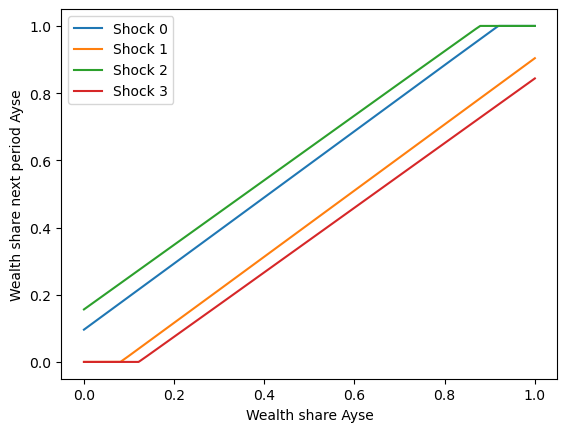

In [119]:
sAplot = np.linspace(0., 1., 1000)

plt.figure()
for z in range(nZ):
    plt.plot(sAplot, sAnextguessnew[z](sAplot), label='Shock '+str(z))
plt.xlabel('Wealth share Ayse')
plt.ylabel('Wealth share next period Ayse')
plt.legend()

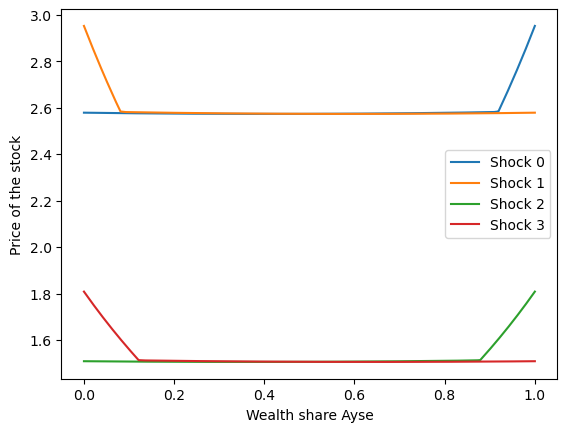

In [120]:
plt.figure()
for z in range(nZ):
    plt.plot(sAplot, qguessnew[z](sAplot), label='Shock '+str(z))
plt.xlabel('Wealth share Ayse')
plt.ylabel('Price of the stock')
plt.legend()

### Solve the model
To solve the model we iteratively update policy and price functions until convergence.

In [121]:
def solve_model(sAgrid, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ, nsA, tol = 1e-9, maxiter = 1000):
    """
    This function solves the model by iterating over the update_functions until the policy and price functions converge.

    Args:
    sAgrid: array, the grid for the wealth share of Ayse
    qguess: array of functions, guess for the price function for each shock
    sAnextguess: array of functions, guess for the savings policy of Ayse for each shock
    beta: float, the discount factor
    gamma: float, the relative risk aversion
    Pi: array, the transition matrix
    eA: array, the endowment of Ayse for each shock
    eJ: array, the endowment of Janet for each shock
    d: array, the dividends of the stock for each shock
    nZ: int, the number of exogenous shocks
    nsA: int, the number of grid points for the wealth share
    tol: float, the tolerance level for the convergence criterion
    maxiter: int, the maximum number of iterations

    Returns:
    qguessnew: array, the converged price function
    sAnextguessnew: array, the converged policy function for Ayse
    success: bool, indicates whether the algorithm converged
    """ 

    # initialize the difference and iteration counter
    difference = 10000.
    iter = 0

    # iterate over the update_functions until the maximum difference is smaller than the tolerance level
    while difference > tol and iter < maxiter:
        # update the functions
        qguessnew, sAnextguessnew = update_functions(sAgrid, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ, nsA)

        dif_pol = 0.
        dif_price = 0.

        for z in range(nZ):
            dif_price_shock = np.max(np.abs(qguessnew[z](sAgrid) - qguess[z](sAgrid)))
            dif_pol_shock = np.max(np.abs(sAnextguessnew[z](sAgrid) - sAnextguess[z](sAgrid)))
        
            dif_price = max(dif_price, dif_price_shock)
            dif_pol = max(dif_pol, dif_pol_shock)

        difference = max(dif_price, dif_pol)

        if iter % 10 == 0:
            print('Iteration: ', iter, ' Difference: ', difference)

        # update the guess
        qguess = qguessnew
        sAnextguess = sAnextguessnew

        iter += 1

    # check if the algorithm converged
    success = difference < tol

    return qguessnew, sAnextguess, success

In [122]:
q_sol, sAnext_sol, success = solve_model(sAgrid, qguess, sAnextguess, beta, gamma, Pi, eA, eJ, d, nZ, nsA, tol = 1e-9, maxiter = 1000)

Iteration:  0  Difference:  2.951799999999877
Iteration:  10  Difference:  0.3205035728833394
Iteration:  20  Difference:  0.03400780056741404
Iteration:  30  Difference:  0.003611613722847906
Iteration:  40  Difference:  0.0003834884063813604
Iteration:  50  Difference:  4.070583967319408e-05
Iteration:  60  Difference:  4.318950928450249e-06
Iteration:  70  Difference:  4.58030509520313e-07
Iteration:  80  Difference:  4.855078472587593e-08
Iteration:  90  Difference:  5.1438462378428085e-09


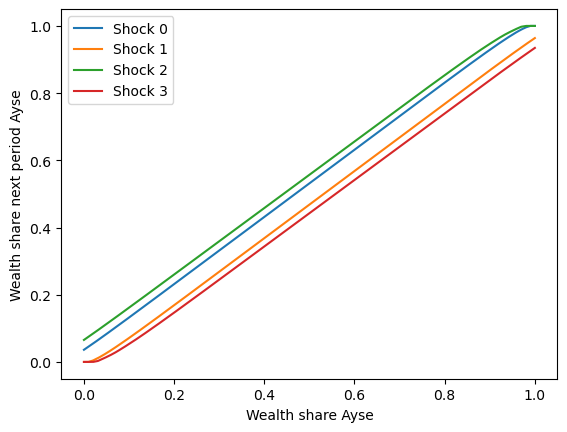

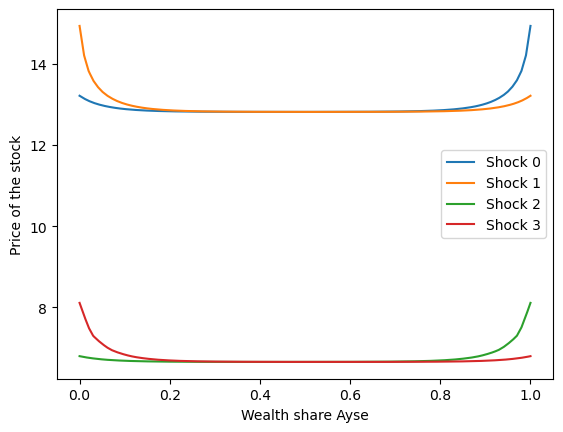

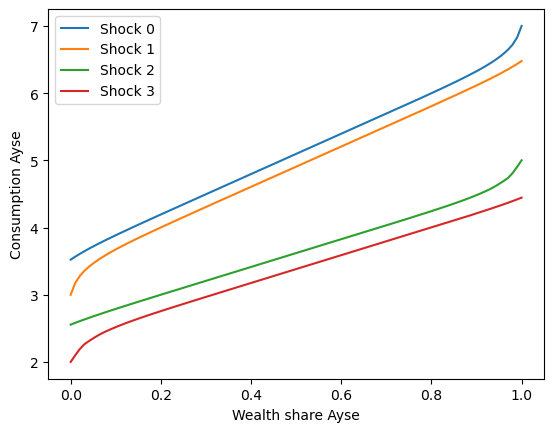

In [123]:
sAplot = np.linspace(0., 1., 1000)

plt.figure()
for z in range(nZ):
    plt.plot(sAplot, sAnext_sol[z](sAplot), label='Shock '+str(z))
plt.xlabel('Wealth share Ayse')
plt.ylabel('Wealth share next period Ayse')
plt.legend()

plt.figure()
for z in range(nZ):
    plt.plot(sAplot, q_sol[z](sAplot), label='Shock '+str(z))
plt.xlabel('Wealth share Ayse')
plt.ylabel('Price of the stock')
plt.legend()

plt.figure()
for z in range(nZ):
    # compute consumption of Ayse
    consA = eA[z] + sAplot * (q_sol[z](sAplot) + d[z]) - q_sol[z](sAplot) * sAnext_sol[z](sAplot)
    plt.plot(sAplot, consA, label='Shock '+str(z))
plt.xlabel('Wealth share Ayse')
plt.ylabel('Consumption Ayse')
plt.legend()

#### Simulate the economy
Now that we solved the model, we can simulate the economy forward. We start out simulating the exogenous process for $z_t$ according to the transition matrix $\Pi$.

In [124]:
def sim_shocks(T, zinitial, Pi, nZ):
    """
    Function simulates the Markov chain for the exogenous shocks z for T periods.
    The transition probabilities are given by the matrix Pi.

    Args:
    T: int, the number of periods
    zinitial: int, the initial shock
    Pi: array, the transition matrix
    nZ: int, the number of possible values for z

    Returns:
    zsim: array, the simulated shocks
    """
    # create the array for the shocks
    zvec = np.arange(nZ)

    # initialize the array for the shocks
    zsim = np.zeros(T, dtype=int)

    # set the initial shock
    zsim[0] = zinitial

    # draw the subsequent shocks
    for t in range(1, T):
        # shock last period
        zlast = zsim[t-1]

        # probabilities for the next shock in the next period
        probabilities = Pi[zlast, :]

        # draw the next shock
        # np.random.choice draws a random sample from zvec according to the given probabilities
        z = np.random.choice(zvec, p=probabilities)

        # store it in the array
        zsim[t] = z


    return zsim

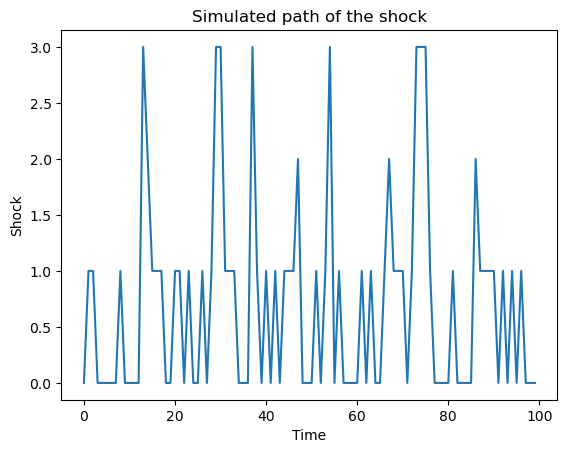

In [125]:
T = 100
zinitial = 0

# try out
zsim = sim_shocks(T, zinitial, Pi, nZ)

# plot the simulated path
plt.figure()
plt.plot(zsim)
plt.xlabel('Time')
plt.ylabel('Shock')
plt.title('Simulated path of the shock')
plt.show()

Now we want to write a function that simulate the whole economy.

In [154]:
def simulate_economy(zinitial, sAinitial, qapprox, sAnextapprox, T, Pi, eA, eJ, d):
    """
    Function simulates the economy for T periods given the initial values for the shock and the wealth share of Ayse,
    as well as the approximated price and policy functions.

    Args:
    zinitial: int, the initial shock
    sAinitial: float, the initial wealth share of Ayse
    qapprox: array of functions, the approximated price function for each shock
    sAnextapprox: array of functions, the approximated policy function for Ayse for each shock
    T: int, the number of periods
    Pi: array, the transition matrix
    eA: array, the endowment of Ayse for each shock
    eJ: array, the endowment of Janet for each shock
    d: array, the dividends of the stock for each shock

    Returns:
    simdict: dictionary, the simulated values, including:
        sAsim: array, the simulated wealth share of Ayse
        qsim: array, the simulated price of the stock
        consAsim: array, the simulated consumption of Ayse
        consJsim: array, the simulated consumption of Janet
        eAsim: array, the simulated endowment of Ayse
        eJsim: array, the simulated endowment of Janet
        dsim: array, the simulated dividends of the stock
        zsim: array, the simulated shocks
        wealthAsim: array, the simulated wealth of Ayse
        wealthJsim: array, the simulated wealth of Janet
    """

    # simulate the exogenous shocks
    zsim = sim_shocks(T, zinitial, Pi, nZ)

    # initialize the arrays for the simulated values
    sAsim = np.zeros(T)
    qsim = np.zeros(T)
    consAsim = np.zeros(T)
    consJsim = np.zeros(T)
    eAsim = np.zeros(T)
    eJsim = np.zeros(T)
    dsim = np.zeros(T)
    wealthAsim = np.zeros(T)
    wealthJsim = np.zeros(T)


    # set the initial values
    sAsim[0] = sAinitial
    z = zsim[0]
    qsim[0] = qapprox[z](sAsim[0])
    sAnext = sAnextapprox[z](sAsim[0])
    consAsim[0] = eA[z] + sAsim[0] * (qsim[0] + d[z]) - qsim[0] * sAnext
    consJsim[0] = eJ[z] + (1. - sAsim[0]) * (qsim[0] + d[z]) - qsim[0] * (1. - sAnext)
    eAsim[0] = eA[z]
    eJsim[0] = eJ[z]
    dsim[0] = d[z]
    wealthAsim[0] = sAsim[0] * (qsim[0] + d[z])
    wealthJsim[0] = (1. - sAsim[0]) * (qsim[0] + d[z])

    # simulate the economy
    for t in range(1, T):
        # read out shock
        z = zsim[t]

        # read out the wealth share of Ayse in the beginning of the period
        sAsim[t] = sAnext

        # compute the price of the stock
        qsim[t] = qapprox[z](sAsim[t])
        
        # compute the wealth share of Ayse in the next period
        sAnext = sAnextapprox[z](sAsim[t])

        # compute the consumption of Ayse and Janet
        consAsim[t] = eA[z] + sAsim[t] * (qsim[t] + d[z]) - qsim[t] * sAnext
        consJsim[t] = eJ[z] + (1. - sAsim[t]) * (qsim[t] + d[z]) - qsim[t] * (1. - sAnext)
        
        # store the endowments and dividends
        eAsim[t] = eA[z]
        eJsim[t] = eJ[z]
        dsim[t] = d[z]

        # store the wealth of Ayse and Janet
        wealthAsim[t] = sAsim[t] * (qsim[t] + d[z])
        wealthJsim[t] = (1. - sAsim[t]) * (qsim[t] + d[z])

    # store the simulated values in a dictionary
    simdict = {'sAsim': sAsim, 'qsim': qsim, 'consAsim': consAsim, 'consJsim': consJsim, 'eAsim': eAsim, 'eJsim': eJsim, 'dsim': dsim, "zsim": zsim, "wealthAsim": wealthAsim, "wealthJsim": wealthJsim}
    return simdict

In [155]:
# try it out

T = 100
zinitial = 0
sAinitial = 0.5


simdict = simulate_economy(zinitial, sAinitial, q_sol , sAnext_sol, T, Pi, eA, eJ, d)

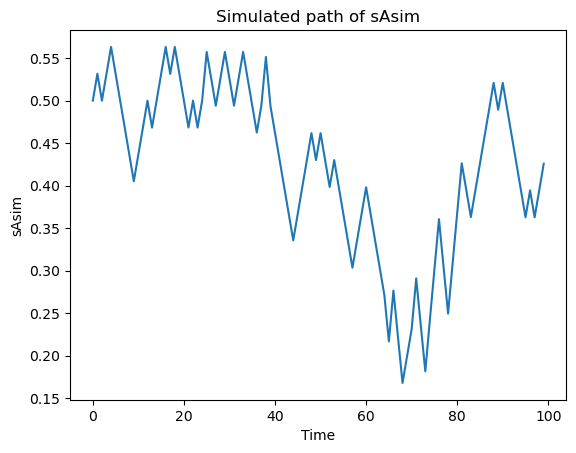

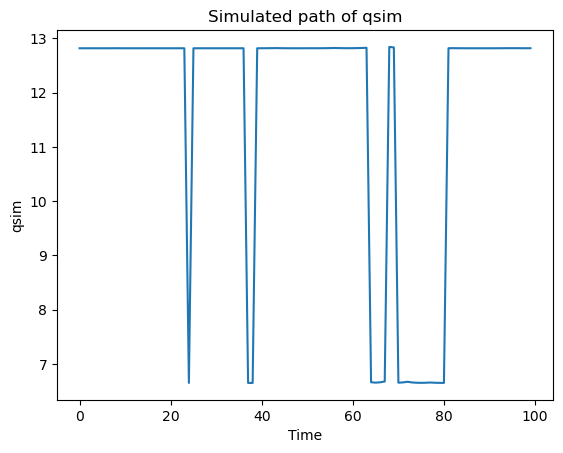

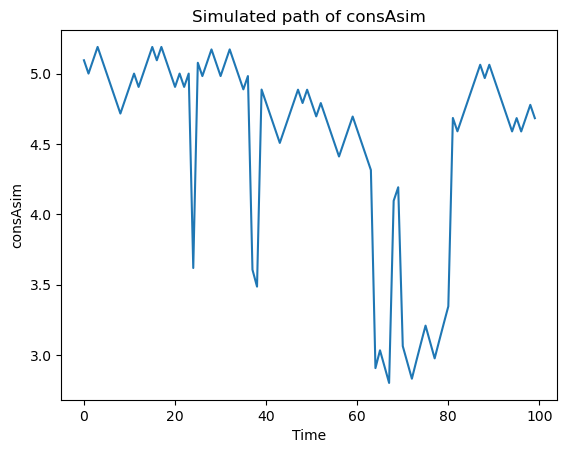

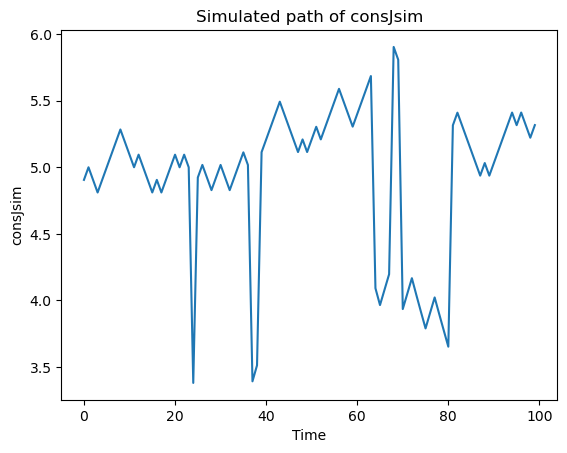

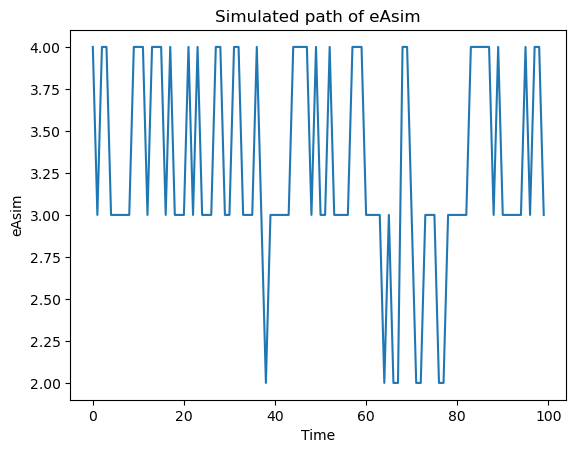

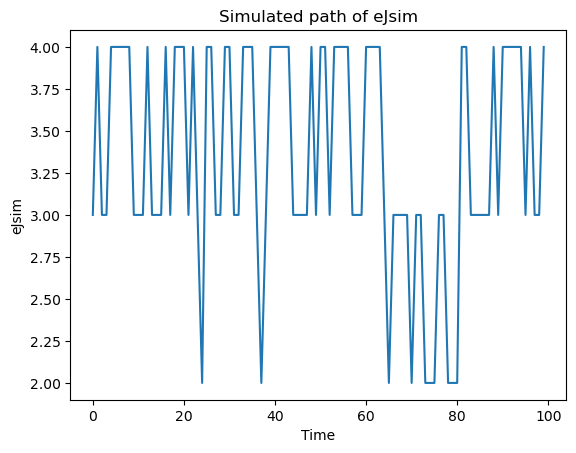

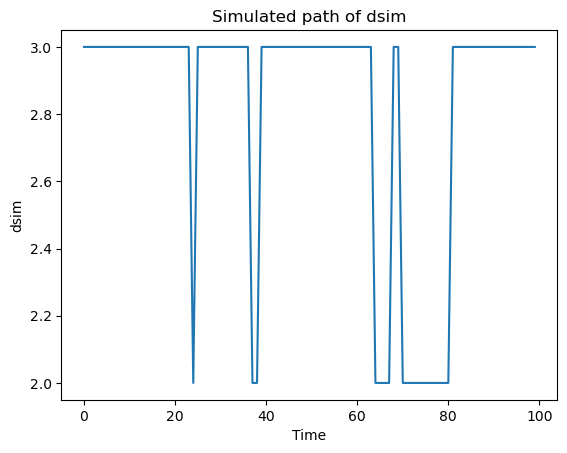

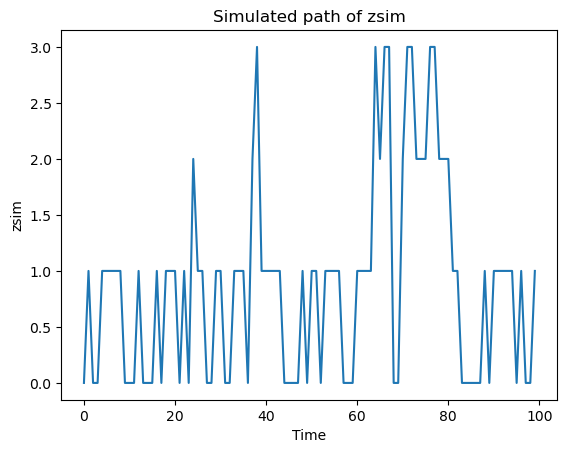

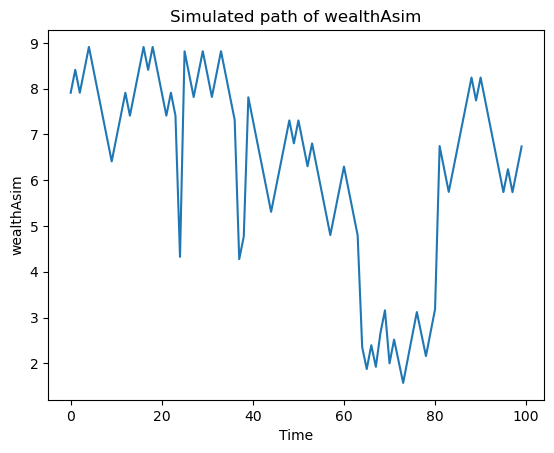

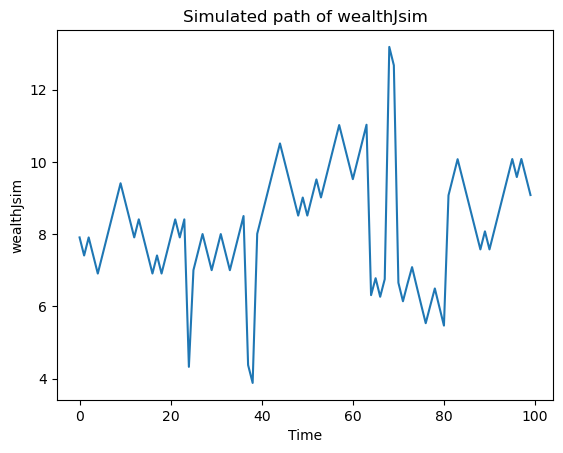

In [156]:
# lets see what we found

for key in simdict.keys():
    plt.figure()
    plt.plot(simdict[key])
    plt.xlabel('Time')
    plt.ylabel(key)
    plt.title('Simulated path of ' + key)
    plt.show()

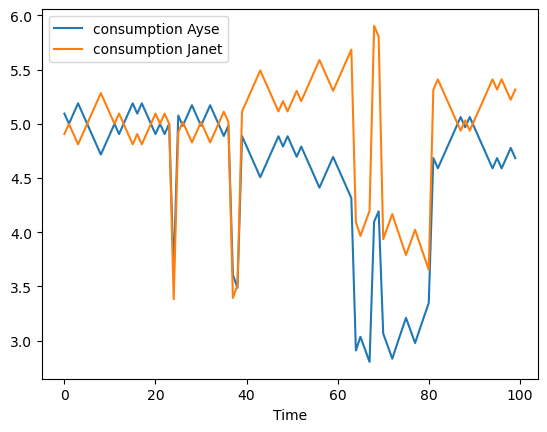

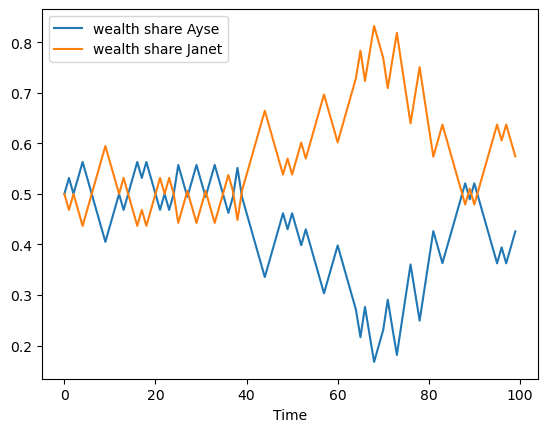

In [157]:
plt.figure()
plt.plot(simdict["consAsim"], color = "C0", label='consumption Ayse')
plt.plot(simdict["consJsim"], color = "C1", label='consumption Janet')
plt.xlabel('Time')
plt.legend()
plt.show()

plt.figure()
plt.plot(simdict["sAsim"], color = "C0", label='wealth share Ayse')
plt.plot(1 - simdict["sAsim"], color = "C1", label='wealth share Janet')
plt.xlabel('Time')
plt.legend()
plt.show()

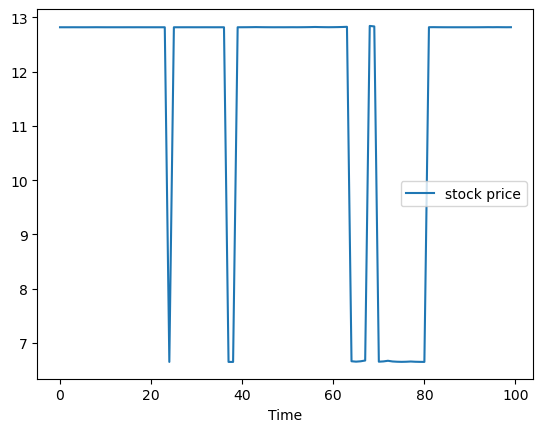

In [158]:
plt.figure()
plt.plot(simdict["qsim"], color = "C0", label='stock price')
plt.xlabel('Time')
plt.legend()
plt.show()

In [159]:
# try a longer simulation

# try it out

T = 10000
zinitial = 0
sAinitial = 0.5


simdict = simulate_economy(zinitial, sAinitial, q_sol , sAnext_sol, T, Pi, eA, eJ, d)

In [160]:
# compute returns

stock_returns = (simdict["qsim"][1:] + simdict["dsim"][1:]) / simdict["qsim"][:-1] - 1

print("mean stock returns = ", 100 * np.mean(stock_returns), "%")
print("std stock returns = ", 100 * np.std(stock_returns), "%")

mean stock returns =  28.60208279036668 %
std stock returns =  35.24899623691761 %


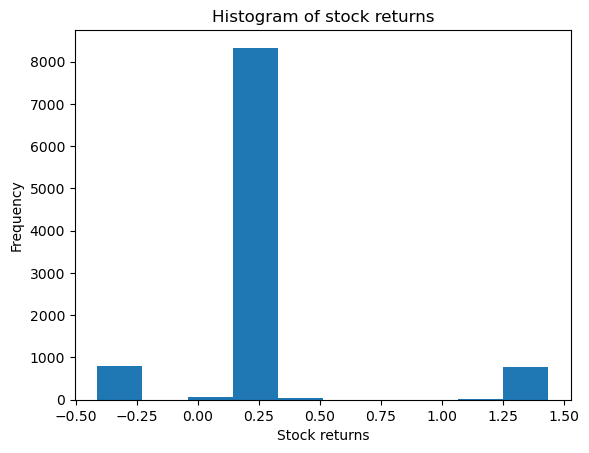

In [161]:
plt.hist(stock_returns)
plt.xlabel('Stock returns')
plt.ylabel('Frequency')
plt.title('Histogram of stock returns')
plt.show()

In [162]:
consumption_growth_A = simdict["consAsim"][1:] / simdict["consAsim"][:-1] - 1
consumption_growth_J = simdict["consJsim"][1:] / simdict["consJsim"][:-1] - 1

Cons_total = simdict["consAsim"] + simdict["consJsim"]
consumption_growth_total = Cons_total[1:] / Cons_total[:-1] - 1

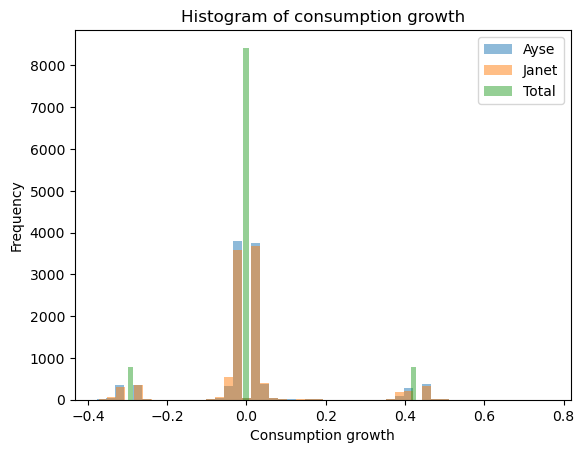

In [163]:
plt.hist(consumption_growth_A, bins = 50, alpha = 0.5, label = 'Ayse')
plt.hist(consumption_growth_J, bins = 50, alpha = 0.5, label = 'Janet')
plt.hist(consumption_growth_total, bins = 50, alpha = 0.5, label = 'Total')
plt.xlabel('Consumption growth')
plt.ylabel('Frequency')
plt.title('Histogram of consumption growth')
plt.legend()

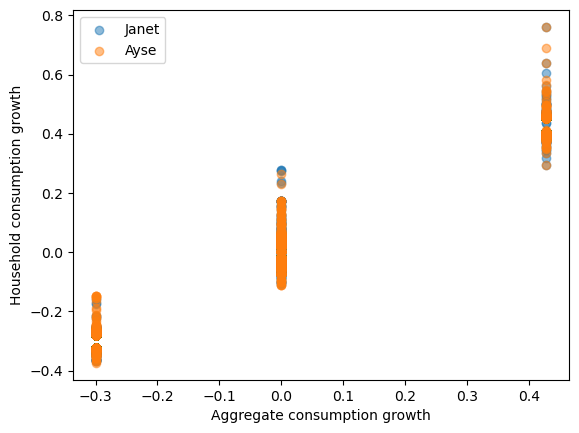

In [152]:
plt.scatter(consumption_growth_total, consumption_growth_J, alpha= 0.5, label = "Janet")
plt.scatter(consumption_growth_total, consumption_growth_A, alpha= 0.5, label = "Ayse")
plt.legend()
plt.xlabel('Aggregate consumption growth')
plt.ylabel('Household consumption growth')
plt.show()

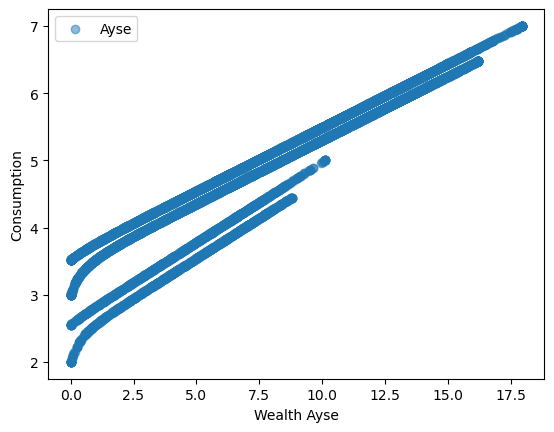

In [169]:
plt.scatter(simdict["wealthAsim"], simdict["consAsim"], alpha = 0.5, label = "Ayse")
plt.legend()
plt.xlabel('Wealth Ayse')
plt.ylabel('Consumption')
plt.show()

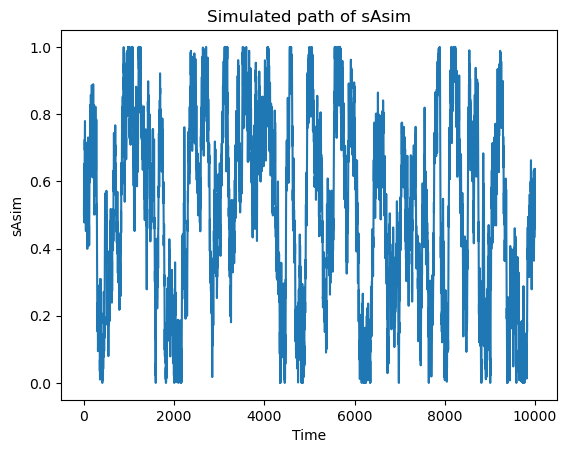

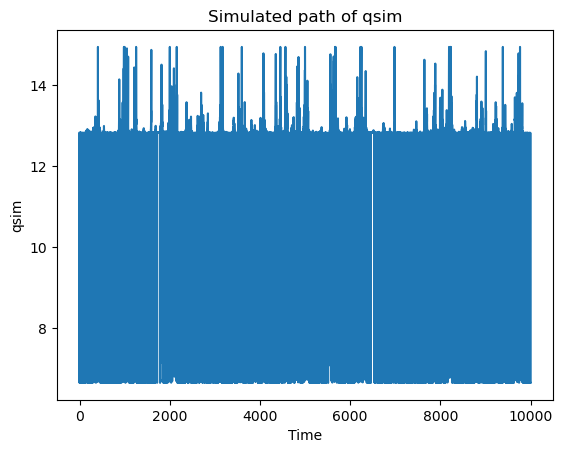

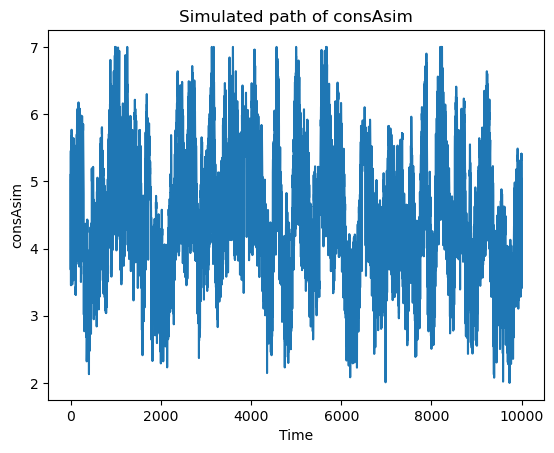

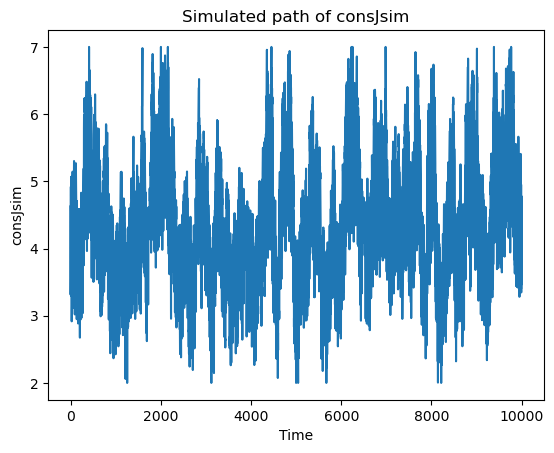

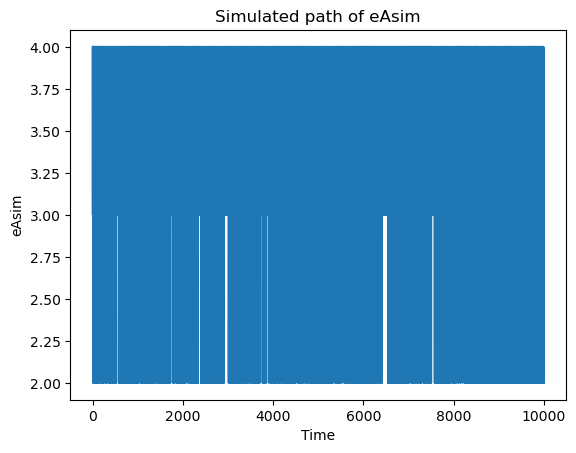

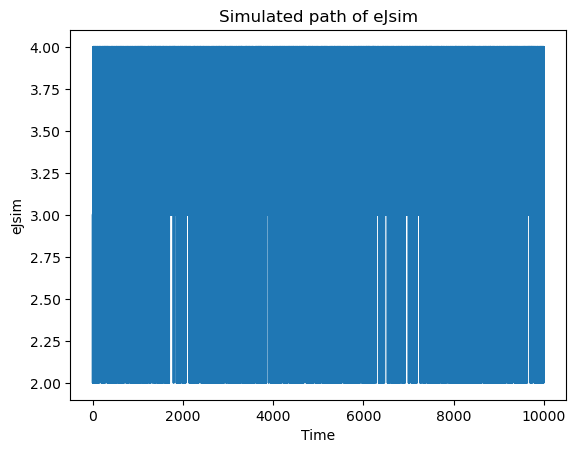

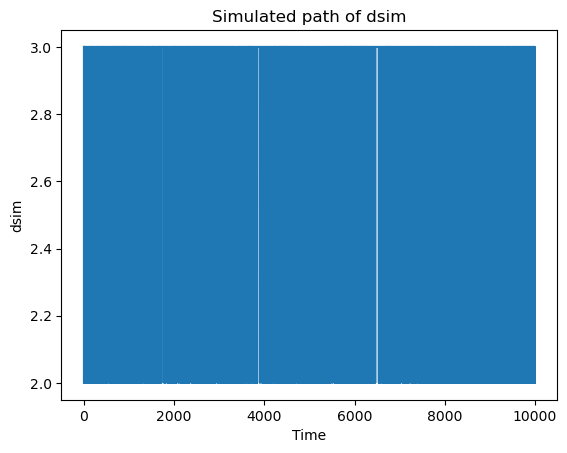

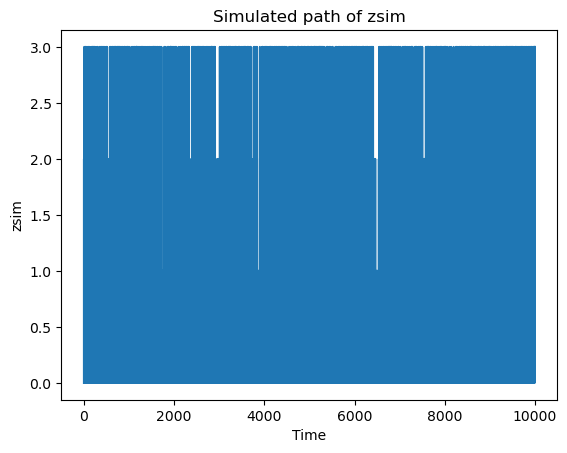

In [140]:
# lets see what we found

for key in simdict.keys():
    plt.figure()
    plt.plot(simdict[key])
    plt.xlabel('Time')
    plt.ylabel(key)
    plt.title('Simulated path of ' + key)
    plt.show()